# Logistic regression using numpy
### Predicting sentiment from product reviews

This notebook builds on Coursera course: Machine Learning: Classification (week2)

It demonstrated details behind logistic regression by implementing it in numpy, and demonstrated the influence of step size on trainig process.

![title](logistic_regression_from_scratch_.png)


### Libraries

In [1]:
import pandas as pd
import string
import json
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt

### Functions

In [2]:
def load_dataset_from_csv(path_to_dataset):
    dataset = pd.read_csv(path_to_dataset)
    return dataset

In [3]:
def remove_na(dataset,column):
    print("n/a before: " + str(dataset[column].isnull().sum()))
    dataset[column].fillna('',inplace = True)
    print("n/a before: " + str(dataset[column].isnull().sum()))

In [4]:
def remove_punctuation(text):
    return text.translate(str.maketrans('', '',string.punctuation))

In [5]:
def read_json(json_path):
    f = open(json_path)
    data = json.load(f)
    f.close()
    return data

In [6]:
def get_numpy_data(dataframe, features, label):
    dataframe['constant'] = 1
    features = ['constant'] + features
    features_frame = dataframe[features]
    feature_matrix = features_frame.to_numpy()
    label_sarray = dataframe[label]
    label_array = label_sarray.to_numpy()
    return(feature_matrix, label_array)

In [7]:
def predict_probability(feature_matrix, coefficients):
    '''P(y_i = +1 | x_i, w)'''
    scores = np.dot(feature_matrix,coefficients)
    predictions = 1. / (1 + np.exp(-scores)) # logistic function
    return predictions

In [8]:
def feature_derivative(errors, feature):     
    # Compute the dot product of errors and feature
    derivative = np.dot(errors,feature)
    return derivative

In [9]:
def compute_log_likelihood(feature_matrix, sentiment, coefficients):
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    lp = np.sum((indicator-1)*scores - np.log(1. + np.exp(-scores)))
    return lp

In [10]:
def logistic_regression(feature_matrix, sentiment, initial_coefficients, step_size, max_iter):
    lps = []
    coefficients = np.array(initial_coefficients) 
    for itr in range(max_iter):
        
        # predict probabilities
        predictions = predict_probability(feature_matrix,coefficients)
        
        # compare predictions with labels
        indicator = (sentiment==+1)
        errors = indicator - predictions
        
        for j in range(len(coefficients)): ## TO DO: replace loop with an numpy way
           
            derivative = feature_derivative(errors, feature_matrix[:, j])
            coefficients[j] += step_size * derivative

        # Checking whether log likelihood is increasing
        if itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0:
            lp = compute_log_likelihood(feature_matrix, sentiment, coefficients)
            print('iteration %*d: log likelihood of observed labels = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, lp))
        lp = compute_log_likelihood(feature_matrix, sentiment, coefficients)
        lps.append(lp)
            
    return coefficients,lps

In [11]:
def compute_scores(feature_matrix, coefficients):
    return np.dot(feature_matrix,coefficients)

In [12]:
def score_to_class(score):
    if score > 0:
        return 1
    else:
        return -1

In [13]:
def compute_accuracy(true_labels,predicted_labels):
    accuracy = (true_labels == predicted_labels).sum()/len(predicted_labels)
    return accuracy

### Load and clean dataset

In [14]:
dataset = 'amazon_baby_subset.csv'

In [15]:
products = load_dataset_from_csv(dataset)

In [16]:
products.head()

,name,review,rating,sentiment
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1


In [17]:
products['sentiment'].value_counts()

 1    26579
-1    26493
Name: sentiment, dtype: int64

In [18]:
remove_na(products,'review')

n/a before: 241
n/a before: 0


In [19]:
products['review_clean'] = products['review'].apply(remove_punctuation)

In [20]:
products.head()

,name,review,rating,sentiment,review_clean
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1,All of my kids have cried nonstop when I tried...
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1,We wanted to get something to keep track of ou...
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1,My daughter had her 1st baby over a year ago S...
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1,One of babys first and favorite books and it i...
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1,Very cute interactive book My son loves this b...


### count words and prepare word count matrix

In [21]:
important_words = read_json('important_words.json')

In [22]:
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))
    

/tmp/ipykernel_36101/1448526264.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  products[word] = products['review_clean'].apply(lambda s : s.split().count(word))


In [23]:
products_df = products.copy()

In [24]:
features_matrix , sentiment = get_numpy_data(products_df,important_words,'sentiment')

### train model with different step sizes

In [25]:
coefficients_4,lps_4 = logistic_regression(features_matrix, sentiment, initial_coefficients=np.zeros(194),
                                   step_size=1e-4, max_iter=301)

iteration   0: log likelihood of observed labels = -32421.40457758
iteration   1: log likelihood of observed labels = -32361.44206679
iteration   2: log likelihood of observed labels = -46284.52561600
iteration   3: log likelihood of observed labels = -76428.62370127
iteration   4: log likelihood of observed labels = -78302.76681108
iteration   5: log likelihood of observed labels = -61756.91248927
iteration   6: log likelihood of observed labels = -65412.29017649
iteration   7: log likelihood of observed labels = -52088.67904541
iteration   8: log likelihood of observed labels = -52970.08854271
iteration   9: log likelihood of observed labels = -45218.93727170
iteration  10: log likelihood of observed labels = -45361.30108853
iteration  11: log likelihood of observed labels = -40648.70439891
iteration  12: log likelihood of observed labels = -40837.87419519
iteration  13: log likelihood of observed labels = -37737.60805148
iteration  14: log likelihood of observed labels = -38096.9019

In [26]:
coefficients_5,lps_5 = logistic_regression(features_matrix, sentiment, initial_coefficients=np.zeros(194),
                                   step_size=1e-5, max_iter=301)

iteration   0: log likelihood of observed labels = -36222.96935992
iteration   1: log likelihood of observed labels = -35712.39105128
iteration   2: log likelihood of observed labels = -35244.87859896
iteration   3: log likelihood of observed labels = -34814.71047654
iteration   4: log likelihood of observed labels = -34417.49249984
iteration   5: log likelihood of observed labels = -34049.53704724
iteration   6: log likelihood of observed labels = -33707.68013590
iteration   7: log likelihood of observed labels = -33389.18706537
iteration   8: log likelihood of observed labels = -33091.68390021
iteration   9: log likelihood of observed labels = -32813.10213697
iteration  10: log likelihood of observed labels = -32551.63288262
iteration  11: log likelihood of observed labels = -32305.68866325
iteration  12: log likelihood of observed labels = -32073.87149461
iteration  13: log likelihood of observed labels = -31854.94611400
iteration  14: log likelihood of observed labels = -31647.8174

In [27]:
coefficients_6,lps_6 = logistic_regression(features_matrix, sentiment, initial_coefficients=np.zeros(194),
                                   step_size=1e-6, max_iter=301)

iteration   0: log likelihood of observed labels = -36728.95079539
iteration   1: log likelihood of observed labels = -36671.80073261
iteration   2: log likelihood of observed labels = -36615.23980812
iteration   3: log likelihood of observed labels = -36559.25213411
iteration   4: log likelihood of observed labels = -36503.82297269
iteration   5: log likelihood of observed labels = -36448.93861776
iteration   6: log likelihood of observed labels = -36394.58628954
iteration   7: log likelihood of observed labels = -36340.75404060
iteration   8: log likelihood of observed labels = -36287.43067208
iteration   9: log likelihood of observed labels = -36234.60565908
iteration  10: log likelihood of observed labels = -36182.26908422
iteration  11: log likelihood of observed labels = -36130.41157845
iteration  12: log likelihood of observed labels = -36079.02426832
iteration  13: log likelihood of observed labels = -36028.09872904
iteration  14: log likelihood of observed labels = -35977.6269

In [28]:
coefficients_7,lps_7 = logistic_regression(features_matrix, sentiment, initial_coefficients=np.zeros(194),
                                   step_size=1e-7, max_iter=301)

iteration   0: log likelihood of observed labels = -36780.91768478
iteration   1: log likelihood of observed labels = -36775.13434712
iteration   2: log likelihood of observed labels = -36769.35713564
iteration   3: log likelihood of observed labels = -36763.58603240
iteration   4: log likelihood of observed labels = -36757.82101962
iteration   5: log likelihood of observed labels = -36752.06207964
iteration   6: log likelihood of observed labels = -36746.30919497
iteration   7: log likelihood of observed labels = -36740.56234821
iteration   8: log likelihood of observed labels = -36734.82152213
iteration   9: log likelihood of observed labels = -36729.08669961
iteration  10: log likelihood of observed labels = -36723.35786366
iteration  11: log likelihood of observed labels = -36717.63499744
iteration  12: log likelihood of observed labels = -36711.91808422
iteration  13: log likelihood of observed labels = -36706.20710739
iteration  14: log likelihood of observed labels = -36700.5020

In [35]:
coefficients_5e4,lps_5e4 = logistic_regression(features_matrix, sentiment, initial_coefficients=np.zeros(194),
                                   step_size=5e-5, max_iter=301)

iteration   0: log likelihood of observed labels = -34266.21753438
iteration   1: log likelihood of observed labels = -32678.23057232
iteration   2: log likelihood of observed labels = -31616.94712507
iteration   3: log likelihood of observed labels = -30903.94663700
iteration   4: log likelihood of observed labels = -30432.59583913
iteration   5: log likelihood of observed labels = -30073.83956614
iteration   6: log likelihood of observed labels = -29775.57644885
iteration   7: log likelihood of observed labels = -29397.91534039
iteration   8: log likelihood of observed labels = -29025.69121038
iteration   9: log likelihood of observed labels = -28573.91060374
iteration  10: log likelihood of observed labels = -28168.96242622
iteration  11: log likelihood of observed labels = -27760.85989478
iteration  12: log likelihood of observed labels = -27421.73326517
iteration  13: log likelihood of observed labels = -27119.28382335
iteration  14: log likelihood of observed labels = -26874.2889

### plot learning curves with different step size

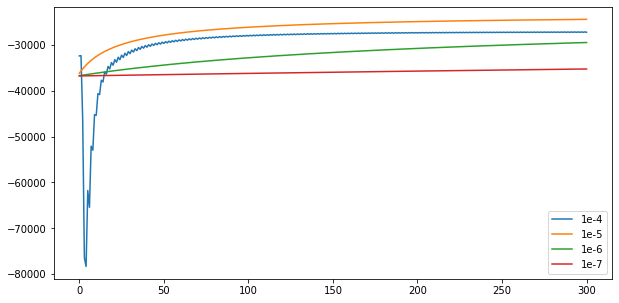

In [41]:
fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(range(len(lps_4)),lps_4)
ax.plot(range(len(lps_5)),lps_5)
ax.plot(range(len(lps_6)),lps_6)
ax.plot(range(len(lps_7)),lps_7)

ax.legend(['1e-4','1e-5','1e-6','1e-7','5e-5']);


the initial screening of step size values indicate that it shoul be lower than 10e-4. Now try values between 10e-5 and 10e-4

### Try step sizes between 1e-4 and 1e-5

In [44]:
step_sizes = [1e-5, 2e-5,3e-5,4e-5,5e-5,6e-5,7e-5,8e-5,9e-5,1e-4]

In [46]:
lps = []
for step_size in step_sizes:
    coefficients_x,lps_x = logistic_regression(features_matrix, sentiment, initial_coefficients=np.zeros(194),
                                   step_size=step_size, max_iter=301)
    lps.append(lps_x)
    

iteration   0: log likelihood of observed labels = -36222.96935992
iteration   1: log likelihood of observed labels = -35712.39105128
iteration   2: log likelihood of observed labels = -35244.87859896
iteration   3: log likelihood of observed labels = -34814.71047654
iteration   4: log likelihood of observed labels = -34417.49249984
iteration   5: log likelihood of observed labels = -34049.53704724
iteration   6: log likelihood of observed labels = -33707.68013590
iteration   7: log likelihood of observed labels = -33389.18706537
iteration   8: log likelihood of observed labels = -33091.68390021
iteration   9: log likelihood of observed labels = -32813.10213697
iteration  10: log likelihood of observed labels = -32551.63288262
iteration  11: log likelihood of observed labels = -32305.68866325
iteration  12: log likelihood of observed labels = -32073.87149461
iteration  13: log likelihood of observed labels = -31854.94611400
iteration  14: log likelihood of observed labels = -31647.8174

iteration  15: log likelihood of observed labels = -26667.02539623
iteration  20: log likelihood of observed labels = -26008.67707736
iteration  30: log likelihood of observed labels = -25301.58169790
iteration  40: log likelihood of observed labels = -24887.07515137
iteration  50: log likelihood of observed labels = -24615.99036713
iteration  60: log likelihood of observed labels = -24426.80078003
iteration  70: log likelihood of observed labels = -24288.77619570
iteration  80: log likelihood of observed labels = -24184.76422896
iteration  90: log likelihood of observed labels = -24104.41297089
iteration 100: log likelihood of observed labels = -24041.10254732
iteration 200: log likelihood of observed labels = -23790.30642400
iteration 300: log likelihood of observed labels = -23735.56399906
iteration   0: log likelihood of observed labels = -33847.29456880
iteration   1: log likelihood of observed labels = -32239.75769120
iteration   2: log likelihood of observed labels = -31581.7133

iteration   3: log likelihood of observed labels = -76428.62370127
iteration   4: log likelihood of observed labels = -78302.76681108
iteration   5: log likelihood of observed labels = -61756.91248927
iteration   6: log likelihood of observed labels = -65412.29017649
iteration   7: log likelihood of observed labels = -52088.67904541
iteration   8: log likelihood of observed labels = -52970.08854271
iteration   9: log likelihood of observed labels = -45218.93727170
iteration  10: log likelihood of observed labels = -45361.30108853
iteration  11: log likelihood of observed labels = -40648.70439891
iteration  12: log likelihood of observed labels = -40837.87419519
iteration  13: log likelihood of observed labels = -37737.60805148
iteration  14: log likelihood of observed labels = -38096.90198600
iteration  15: log likelihood of observed labels = -35906.94136238
iteration  20: log likelihood of observed labels = -34437.86699966
iteration  30: log likelihood of observed labels = -31928.2190

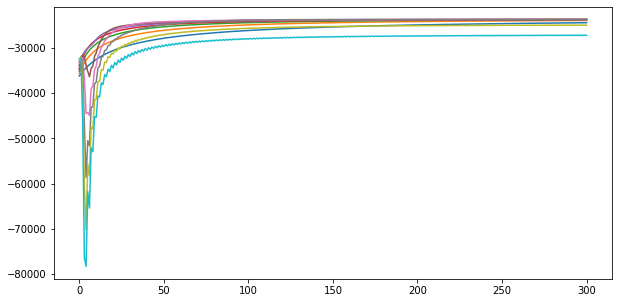

In [47]:
fig, ax = plt.subplots(1,1,figsize = (10,5))
for lp in lps:
    ax.plot(range(len(lp)),lp)

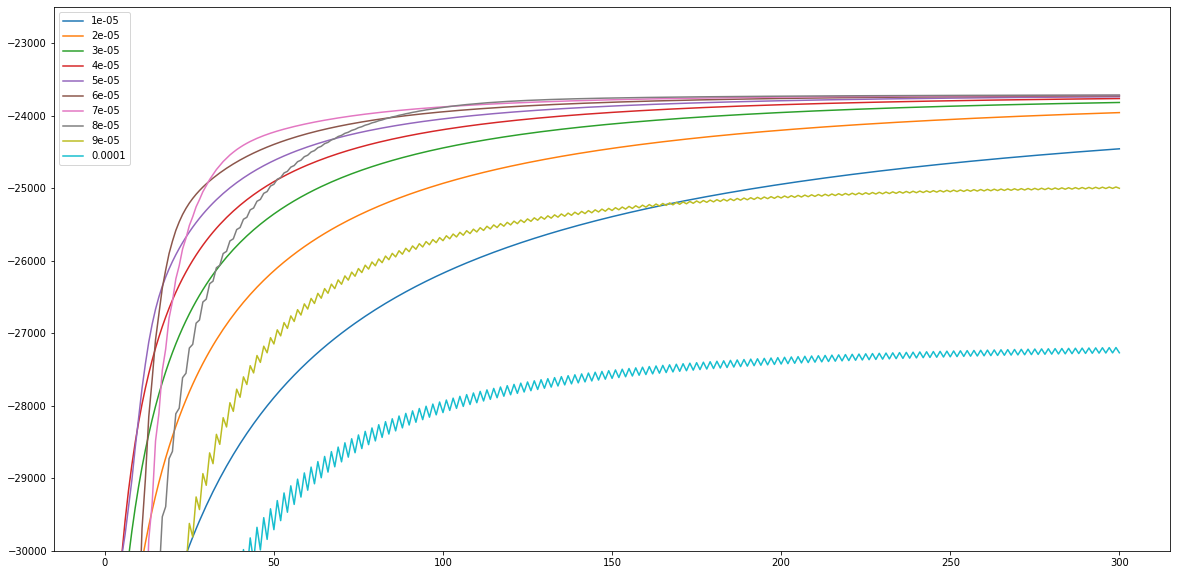

In [52]:
fig, ax = plt.subplots(1,1,figsize = (20,10))
for lp in lps:
    ax.plot(range(len(lp)),lp)
ax.set_ylim(-30000,-22500)
ax.legend([str(step_size) for step_size in step_sizes])

**conclusions** from examined step sized these between 3e-05 and 7e-05 are the most promising ones. Obviously this is not the correct way to approach this optimization as it should be done using either validation set or cross validation

### accuracy with different step sizes

In [30]:
for coefficients in [coefficients_4,coefficients_5,coefficients_6,coefficients_7]:
    scores = compute_scores(feature_matrix=features_matrix,coefficients=coefficients)
    classes = [score_to_class(i) for i in scores]
    accuracy = compute_accuracy(sentiment,classes)
    print(accuracy)

0.7662420862224902
0.7877223394633706
0.7683335845643654
0.7518653904130238


### the influence of stepsize on coefficients

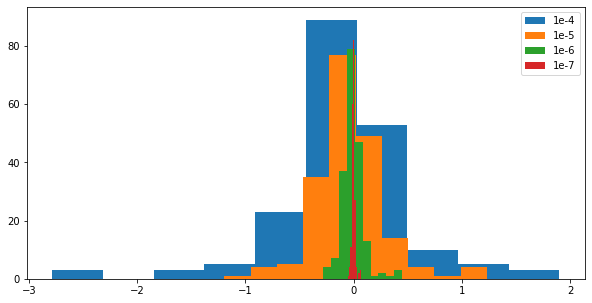

In [40]:
fig,ax = plt.subplots(1,1,figsize = (10,5))

ax.hist(coefficients_4)
ax.hist(coefficients_5)
ax.hist(coefficients_6)
ax.hist(coefficients_7)

ax.legend(['1e-4','1e-5','1e-6','1e-7']);

### most significat words

In [32]:
for coefficients,s in zip([coefficients_4,coefficients_5,coefficients_6,coefficients_7],['1e-4','1e-5','1e-6','1e-7']):
    coeff_args_sorted = np.argsort(coefficients)
    positive = np.array(important_words)[coeff_args_sorted-1][-10:]
    negative = np.array(important_words)[coeff_args_sorted-1][:10]
    print(s)
    print(positive)
    print(negative)

1e-4
['comfortable' 'bit' 'great' 'fits' 'best' 'happy' 'easy' 'love' 'perfect'
 'loves']
['disappointed' 'returned' 'return' 'waste' 'broke' 'idea' 'cheap' 'money'
 'difficult' 'bad']
1e-5
['nice' 'little' 'fits' 'best' 'happy' 'great' 'perfect' 'easy' 'love'
 'loves']
['disappointed' 'return' 'money' 'waste' 'returned' 'broke' 'idea' 'cheap'
 'work' 'thought']
1e-6
['recommend' 'nice' 'happy' 'well' 'perfect' 'little' 'loves' 'great'
 'easy' 'love']
['money' 'disappointed' 'would' 'work' 'product' 'return' 'even' 'waste'
 'back' 'thought']
1e-7
['daughter' 'nice' 'old' 'perfect' 'well' 'loves' 'little' 'easy' 'love'
 'great']
['would' 'product' 'money' 'work' 'even' 'disappointed' 'get' 'back'
 'return' 'monitor']
